# Deutscher CO$_2$-Ausstoß und verbleibendes Budget

In der deutschen Politik gibt es immer wieder Streit darüber, ob Deutschland auf einem guten oder schlechten Weg für die Reduktion des CO$_2$-Ausstoßes ist. Wir haben uns die zugrunde liegenden Zahlen angeschaut.

Die Bwertung der Szenarien ist am Ende stark davon abhängig, welche verbleibenden Budgets man Deutschland zumisst:

* Darf Deutschland weiterhin einer der größten pro Kopf Emitenden bleiben?
* Sollen alle Länder einen Anteil am UNO/IPCC-Restbudget gemäß ihrer Einwohnerzahl bekommen?

Im erstgenannten Fall ist es nicht ausgeschlossen, dass Deutschland das 2°C-Ziel erreicht. Aktuelle Prognosen der Bundesregierung lassen aber ernsthafte Zweifel zu. Das Erreichen des 1.5°C-Ziels erscheint unrealistisch.

Im zweiten Fall geraten beide Ziele innerhalb der nächsten 10 Jahre außer Reichweite und sind nur durch negativ Emissionen erreichbar.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial
from scipy.optimize import curve_fit

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Bevölkerungszahlen

Deutschland hat ca. 80 Millionen Einwohner, auf der Welt sind es ca 7.5 Milliarden. Eine faire Verteilung des CO$_2$ Restbudgets würde für Deutschland ca. 1.1% vorsehen. Deutschlands Anteil an den jährlichen Emissionen ist Stand 2016 ca. 2.2%.

In [2]:
GERMAN_POPULATION = 80e6
WORLD_POPULATION = 7.5e9


german_partition_pc = GERMAN_POPULATION / WORLD_POPULATION
german_partition_em = 0.0223  # Percentage of German emissions in 2016

## Der Datensatz

Aus den Daten des IPCC für die globalen Restbudgets zur Erreichung des 1.5°C/2.0°C-Ziels, berechnen wir die entsprechenden Budgets für Deutschland.

Wir vergleichen dabei drei Szenarien:

* Den Klimaschutzplan 2050 der Bundesregierung
* Eine lineare Reduktion der Emissionen im gleichen Tempo wie von 2001-2015
* Den Projektionsbericht des BMU den sich das BMU nicht zu eigen macht

### Anmerkung:

Wir sind davon ausgegangen, dass die lineare Reduktion ein Worst-Case-Szenario beschreibt. Leider sieht der Projektionsbericht des BMU Deutschland auf einem noch langsameren Pfad.

In [3]:
df = pd.read_csv(
    'co2_emissions_de.csv',
    index_col=0,
    comment='#',
    parse_dates=['year'],
)
df['emissions'] /= 1e3 # kt to Mt

targets_klimaplan = pd.read_csv('targets_klimaplan2050.csv', comment='#', index_col=0, parse_dates=['year'])
df = df.join(targets_klimaplan, how='outer')

prognosis_bmu = pd.read_csv('co2_prognose_2019.csv', comment='#', index_col=0, parse_dates=['year'])
df = df.join(prognosis_bmu, how='outer')

budgets = pd.read_csv('./co2_rest_budgets.csv', comment='#')
difference = (budgets['warming_preindustrial'] - budgets['warming_20062015']).mean()
budgets['warming_preindustrial'] = budgets['warming_20062015'] + difference
budgets['rest_budget'] *= 1e3 # Gt to Mt
budgets['rest_germany_pc'] = budgets['rest_budget'] * german_partition_pc
budgets['rest_germany_em'] = budgets['rest_budget'] * german_partition_em
budgets.set_index('warming_preindustrial', inplace=True)
budgets

,warming_20062015,rest_budget,rest_germany_pc,rest_germany_em
warming_preindustrial,,,,
1.27,0.30,80000.0,853.333333,1784.0
1.37,0.40,230000.0,2453.333333,5129.0
1.47,0.50,380000.0,4053.333333,8474.0
1.50,0.53,420000.0,4480.000000,9366.0
1.57,0.60,530000.0,5653.333333,11819.0
1.60,0.63,570000.0,6080.000000,12711.0
1.67,0.70,680000.0,7253.333333,15164.0
1.75,0.78,800000.0,8533.333333,17840.0
1.77,0.80,830000.0,8853.333333,18509.0


## Datensatz zum CO$_2$-Ausstoß

Die Daten für den tatsächlichen CO$_2$-Ausstoß in Deutschland zwischen 1990 und 2018 kommen vom Umweltbundesamt.

In [4]:
df.loc['2017-12-31', ['target_klimaplan2050', 'prognosis']] = df.loc['2017-12-31', 'emissions']
#df.loc['2050-12-31', 'prognosis'] = df.loc['2050-12-31', 'target_klimaplan2050']

df

,emissions,target_klimaplan2050,prognosis
year,,,
1990-12-31,1250.993,NaN,NaN
1991-12-31,1203.924,NaN,NaN
1992-12-31,1153.796,NaN,NaN
1993-12-31,1144.857,NaN,NaN
1994-12-31,1125.835,NaN,NaN
1995-12-31,1123.035,NaN,NaN
1996-12-31,1141.085,NaN,NaN
1997-12-31,1106.001,NaN,NaN
1998-12-31,1080.729,NaN,NaN


## Vergleich der CO$_2$-Emissionsdaten mit den Szenarien

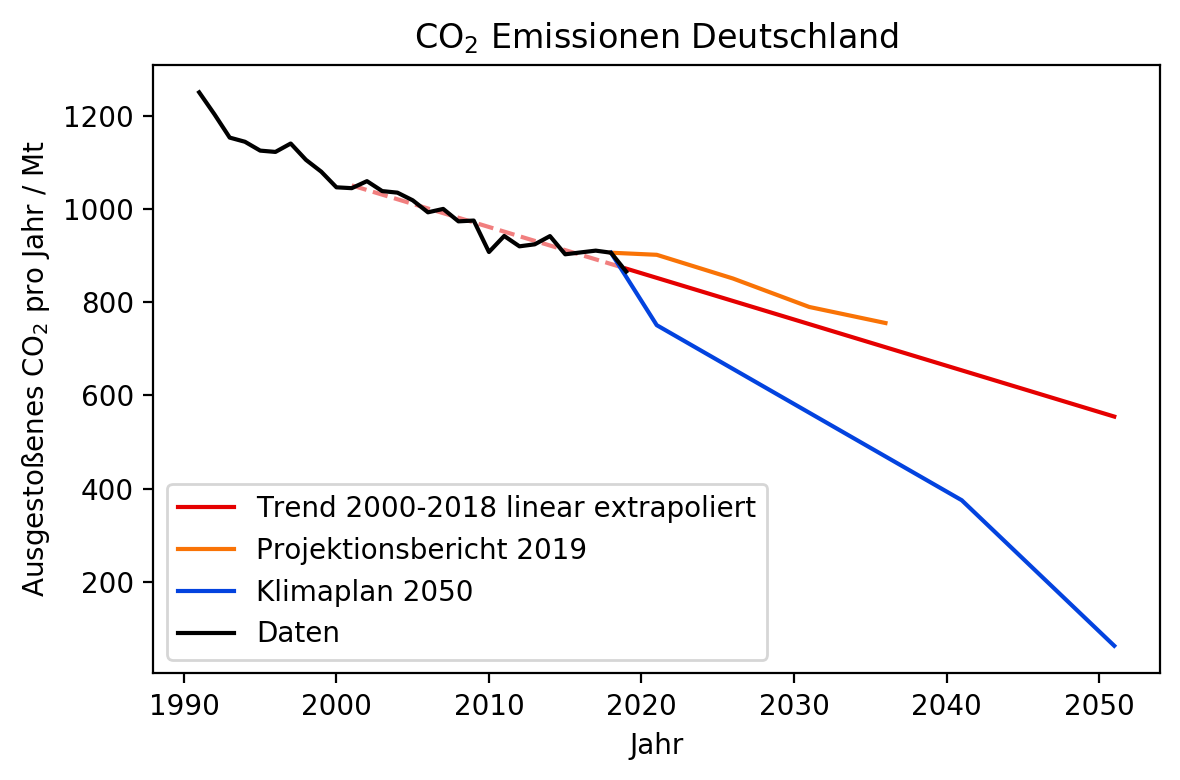

In [5]:
plt.figure(dpi=200)


y = df['emissions']['2000': '2019'].dropna()
x = y.index.year
p = Polynomial.fit(x, y, deg=1)


plt.plot(df['2018':].index, p(df['2018':].index.year), color='xkcd:red', label='Trend 2000-2018 linear extrapoliert')
plt.plot(y.index, p(x), color='xkcd:red', ls='--', alpha=0.5)


plt.plot(df['prognosis'].dropna(), label = 'Projektionsbericht 2019', color='xkcd:orange')
plt.plot(df['target_klimaplan2050'].dropna(), label='Klimaplan 2050', color='xkcd:blue')
plt.plot(df['emissions'], label = 'Daten', color='k')

plt.title('CO$_2$ Emissionen Deutschland')
plt.xlabel('Jahr')
plt.ylabel('Ausgestoßenes CO$_2$ pro Jahr / Mt')
plt.legend()
plt.tight_layout()
plt.savefig('emissions.png', dpi=300)

### Bildbeschreibung

Die Reduktion der CO$_2$-Emissionen in Deutschland zeigt seit einigen Jahren einen linearen Trend auf. Bei Fortsetzung dieses Trends (rote Linie) würde das Ziel "0-Emissionen" erst in ca. 80 Jahren erreicht.

Der Projektionsbericht der Bundesregierung 2019 (gelbe Linie) sieht sogar ein deutlich pessimistischeres Szenario. Insbesondere in den nächsten 15 Jahren ist darin nicht erkennbar, dass die deutschen Anstrengungen zum Klimaschutz zielführend sind.

Der ursprüngliche Klimaplan 2050 (blaue Linie), der als Reaktion auf das Pariser Abkommen entstanden ist, zeigt einen ambitionierteren Weg. Es bleibt in den entsprechenden Dokumenten unklar, wie dieses Reduktionstempo erreicht werden soll.

## Betrachtung des Restbudgets für Deutschland im Planungsszenario der Bundesregierung

Die Bundesregierung geht davon aus, dass Deutschland aus den globalen CO$_2$-Budgets, die vom IPCC errechnet wurden ca. 2.2% zustehen. Danach darf Deutschland pro Kopf doppelt so viel CO$_2$ ausstoßen, wie der durchschnittliche CO$_2$-Ausstoß pro Person auf der Welt ist.

In [6]:
df.loc['2019':, 'linear_trend'] = p(df['2019':].index.year)

for col in ('target_klimaplan2050', 'linear_trend'):
    df.loc['2017':'2018', col] = df.loc['2017':'2018', 'emissions']

In [7]:
interpolated = df.resample('1Y').interpolate()

df_rest = interpolated['2017':].cumsum()
df_rest -= df_rest.loc['2017'].values
df_rest.loc['2036':, 'prognosis'] = np.nan

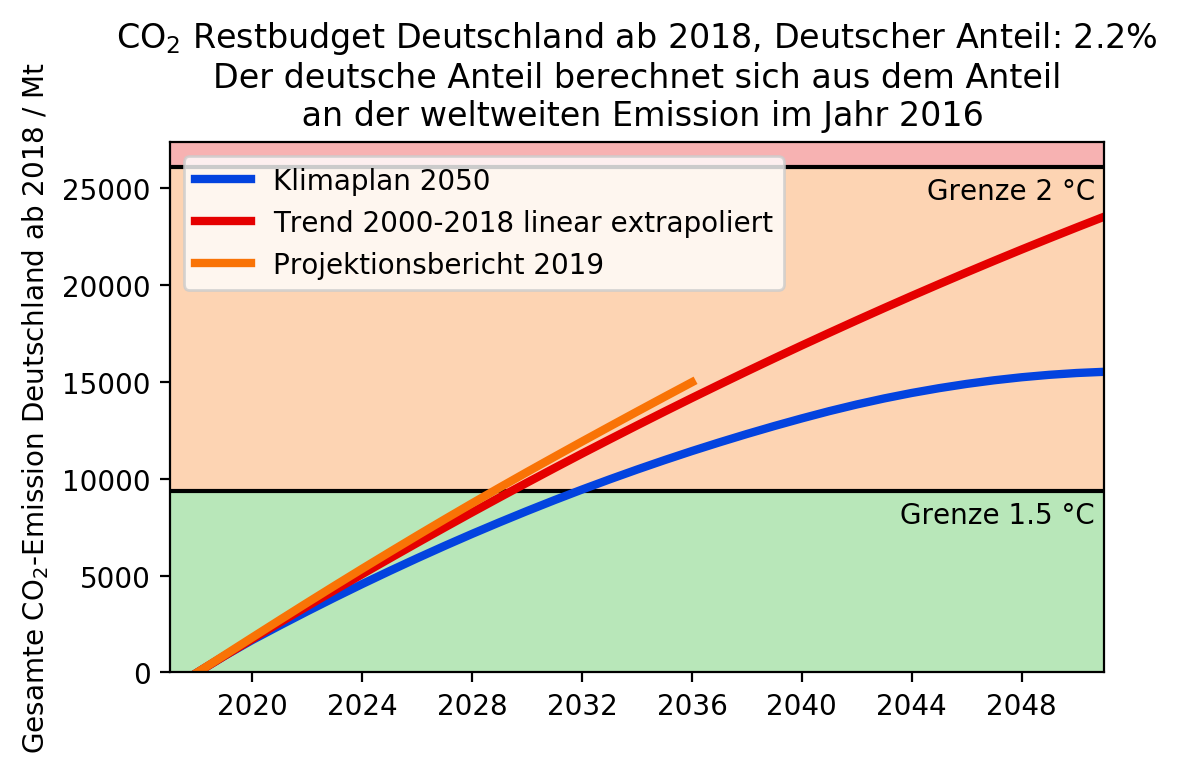

In [8]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1)

targets = {
    '2 °C': budgets.loc[2.0, 'rest_germany_em'],
    '1.5 °C': budgets.loc[1.5, 'rest_germany_em'],    
}

for label, target in targets.items():
    ax.axhline(target, color='k')
    ax.text(df_rest.index.max(), target - 500, 'Grenze ' + label + ' ', va='top', ha='right')

ax.plot(df_rest['target_klimaplan2050'], label='Klimaplan 2050', color='xkcd:blue', lw=3)
ax.plot(df_rest['linear_trend'], label='Trend 2000-2018 linear extrapoliert', color='xkcd:red', lw=3)
ax.plot(df_rest['prognosis'], label='Projektionsbericht 2019', color='xkcd:orange', lw=3)

ax.set_xlim('2017', '2051')
ax.set_ylim(0, None)

ax.fill_between(ax.get_xlim(), targets['2 °C'], ax.get_ylim()[1], color='xkcd:red', alpha=0.3, zorder=-1, lw=0)
ax.fill_between(ax.get_xlim(), targets['2 °C'], targets['1.5 °C'], color='xkcd:orange', alpha=0.3, zorder=-1, lw=0)
ax.fill_between(ax.get_xlim(), targets['1.5 °C'], ax.get_ylim()[0], color='xkcd:green', alpha=0.3, zorder=-1, lw=0)

ax.margins(0)

ax.legend(loc='upper left')

explanation = 'Der deutsche Anteil berechnet sich aus dem Anteil\n an der weltweiten Emission im Jahr 2016'

ax.set_title(f'CO$_2$ Restbudget Deutschland ab 2018, Deutscher Anteil: {german_partition_em:.1%}\n' + explanation)
ax.set_ylabel('Gesamte CO$_2$-Emission Deutschland ab 2018 / Mt')
ax.set_xlabel(' ')


fig.tight_layout()
fig.savefig('co2_restbudget.png', dpi=300)

### Bildbeschreibung

Der Klimaplan 2050 der Bundesregierung erfüllt unter den gegebenen Annahmen von 2.2% Anteil an den IPCC Restbudgets die Bedingungen des Pariser Abkommens weitgehend. Würden alle Staaten unter den gleichen Annahmen handeln, läge die errechnete Erderwärmung bei ca. 1.6 - 1.7 °C.

Der aktuelle Trend (rote Linie) und der Projektionsbericht 2019 der Bundesregierung (gelbe Linie) deuten für Deutschland einen abweichenden Weg an. Das Budget für das 1.5°C-Ziel wird demnach schon in der nächsten Dekade überschritten werden. Bis 2050 ist aus heutiger Sicht in beiden Szenarien nicht erkennbar, ob Klimaneutralität erreicht wird. Das Restbudget zur Begrenzung der Erderwärmung auf 2°C wird in den Szenarien möglicherweise noch nach 2050 überschritten.

## Betrachtung des Restbudgets für Deutschland im pro Kopf Szenario

Es gibt Zweifel daran, ob Deutschland einen erhöhten pro Kopf Anteil an den globalen restbudgets rechfertigen kann. Im Gegensatz zu den obigen Annahmen würden Deutschland, gewichtet nach der Bevölkerungszahl, 1.1% des IPCC Restbudgets zustehen.

Das ist nicht das für Deutschland schwierigste Szenario. Wenn alle bisherigen Emissionen mit eingerechnet würden, sähe das Bild noch etwas anders aus. Deutschland stünden deutlich weniger als 1.1% des restbudgets zu. Dieses Szenario wird hier aber nicht betrachtet.

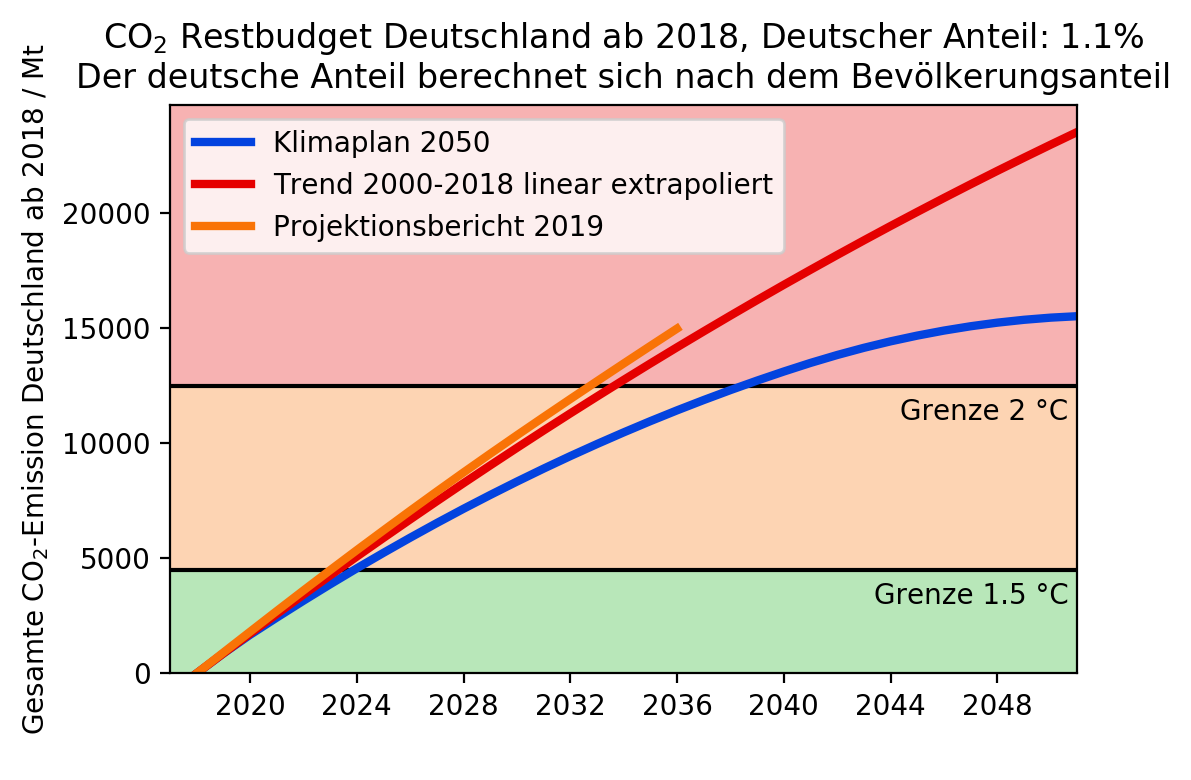

In [9]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1)

targets = {
    '2 °C': budgets.loc[2.0, 'rest_germany_pc'],
    '1.5 °C': budgets.loc[1.5, 'rest_germany_pc'],    
}

for label, target in targets.items():
    ax.axhline(target, color='k')
    ax.text(df_rest.index.max(), target - 500, 'Grenze ' + label + ' ', va='top', ha='right')

ax.plot(df_rest['target_klimaplan2050'], label='Klimaplan 2050', color='xkcd:blue', lw=3)
ax.plot(df_rest['linear_trend'], label='Trend 2000-2018 linear extrapoliert', color='xkcd:red', lw=3)
ax.plot(df_rest['prognosis'], label='Projektionsbericht 2019', color='xkcd:orange', lw=3)

ax.set_xlim('2017', '2051')
ax.set_ylim(0, None)

ax.fill_between(ax.get_xlim(), targets['2 °C'], ax.get_ylim()[1], color='xkcd:red', alpha=0.3, zorder=-1, lw=0)
ax.fill_between(ax.get_xlim(), targets['2 °C'], targets['1.5 °C'], color='xkcd:orange', alpha=0.3, zorder=-1, lw=0)
ax.fill_between(ax.get_xlim(), targets['1.5 °C'], ax.get_ylim()[0], color='xkcd:green', alpha=0.3, zorder=-1, lw=0)

ax.margins(0)

ax.legend(loc='upper left')


explanation = 'Der deutsche Anteil berechnet sich nach dem Bevölkerungsanteil'

ax.set_title(f'CO$_2$ Restbudget Deutschland ab 2018, Deutscher Anteil: {german_partition_pc:.1%}\n' + explanation)
ax.set_ylabel('Gesamte CO$_2$-Emission Deutschland ab 2018 / Mt')
ax.set_xlabel(' ')


fig.tight_layout()
fig.savefig('co2_restbudget_pc.png', dpi=300)

### Bildbeschreibung

Die farbigen Kurven haben jeweils den gleichen Verlauf, wie in der vorherigen Abbildung. Geändert sind nur die Grenzen zur Erreichung der Ziele des Pariser Abkommens. Die Änderung ergibt sich aus der Abweichenden Annahme, dass hier alle Staaten einen gleichen pro Kopf Anteil an den IPCC-Restbudgets verlangen. Deutschlands Budget wäre dadurch ziemlich genau um den Faktor 2 kleiner.

Diese Darstellung zeigt, wie wenig ambitioniert die deutschen Pläne sind. Selbst das optimistische und mittlerweile überholte Szenario des Klimaplans 2050 (blaue Linie) der Bundesregierung würde schon vor 2040 das Budget für das 2°C-Ziel überschreiten. Über die realistischeren Szenarien, die auf den aktuellen Zahlen basieren müssen wir in diesem Fall gar nicht reden. Beide Ziele würde innerhalb der nächsten Dekade fallen.

## Fazit

In den tatsächlichen Zahlen zu den deutschen CO$_2$-Emissionen zeigt sich ein langsamer linearer Trend. Dieser Trend führt in Deutschland erst in ca. 80 Jahren zu CO$_2$-Neutralität.

Die Ziele der Bundesregierung zur CO$_2$-Reduktion sind nicht ambitioniert. Das Erreichen dieser Ziele ist selbst nach den durch die Bundesregierung in Auftrag gegebenen Studien ohne zusätzliche Maßnahmen ausgeschlossen.

Setzt man nur annähernd faire Bedingungen zur globalen Veteilung der Restbudgets an, zerfallen alle erkennbaren Ziele. Der politische Optimismus, die aktuell gesetzten Ziele reichten aus, leiten sich aus der Annahme ab, dass insbesondere kleinere und weniger industrialisierte Staaten die erhöhten Emissionen der Industrienationen akzeptieren und selbst in der Lage sind, ihre eigenen Emissionen im gleichen Tempo zu reduzieren.

Diese Annahme erscheint aus wissenschaftlicher Sicht unrealistisch.